In [1]:
import torch
import torch.nn as nn
import numpy as np

%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# 0. Problem 
# Binary classification case : is y(x) = 0 or 1 ?

#### Create Training Samples

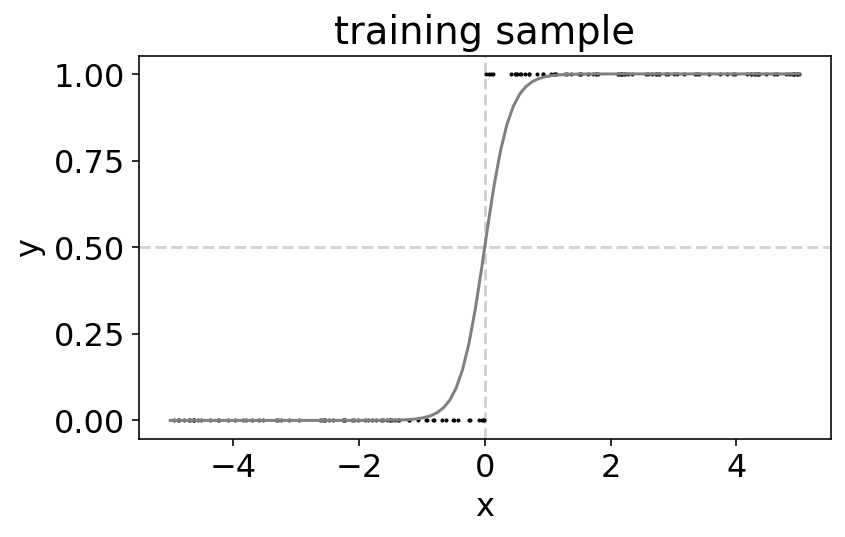

In [2]:
def logistic_function(weights, x, discrete_mode=0):
    '''logistic function
        (to check whether the weights extracted from a trained model make sense)
    '''
    y = weights[0]*x + weights[1]
    y = np.exp(y) / (1.+np.exp(y))
    
    if discrete_mode:
        y[y>=0.5] = 1.0
        y[y<0.5] = 0.0

    return y
    
#x = np.array([-4.8, -4.5, -3.6, -2.5, -1.3, -0.5, 0.2, 0.6, 1.5, 2.2, 3.2, 5.0])
#y = np.array([ 0.0,  0.0,  0.0,  0.0,  1.0,  0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

x = np.random.uniform(-5., 5., 150)
weights_true = [5., 0.]
y = logistic_function(weights_true, x, discrete_mode=1)


#---------------

plt.rc('font', size=16)
fig, ax = plt.subplots(1, 1)

ax.scatter(x, y, color='k', s=1)

xl=np.linspace(-5, 5, 100)
yl=logistic_function(weights_true, xl, discrete_mode=0)
ax.plot(xl, yl, color='gray')

ax.axhline(y=0.5, color='lightgray', zorder=-1, ls='--')
ax.axvline(x=0. , color='lightgray', zorder=-1, ls='--')
ax.set_title('training sample')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

In [3]:
# torch tensor
X = torch.from_numpy(x.astype(np.float32))
Y = torch.from_numpy(y.astype(np.float32))

# turn training X and Y into the right shape = n_samples x n_features = 11 x 1
X = X.view(-1,1)
Y = Y.view(-1,1)

print("X.shape", X.shape)
print("Y.shape", Y.shape)

X.shape torch.Size([150, 1])
Y.shape torch.Size([150, 1])


# 1. Method 1

### Model | BCE Loss | optimizer

** logistic function is basically equivalent to the sigmoid activation

In [4]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        '''logistic function
            p(X) = exp(w0+w1*x) / ( 1+ exp(w0+w1*x) )
            equivalent to torch.sigmoid 
        '''
        out = self.linear(x)
        #y = torch.exp(out) / (1.+torch.exp(out))
        y = torch.sigmoid(out)
        return y

In [5]:
def BinaryCrossEntropyLoss(output, target):        
    loss = - ( target*torch.log(output) + (1.-target)*torch.log(1.-output) ).mean()
    return loss

BCELoss = nn.BCELoss()

#### Training loop

In [6]:
def training_loop1(num_epochs=500, debug_mode=0):
    
    for epoch in range(num_epochs):
        # forward pass
        Y_predict = model1(X)
        # loss
        # my own loss function
        loss = BinaryCrossEntropyLoss(Y_predict, Y)
    
        # backward pass
        loss.backward()
    
        # updates
        optimizer1.step()
    
        # zero gradients
        optimizer1.zero_grad()
    
        if (epoch+1) % 100 == 0 :
            if debug_mode:
                loss_torch = BCELoss(Y_predict, Y).detach()
                print(f'epoch: {epoch+1}, loss={loss.item():.4f}, nn.BCELoss={loss_torch.item():.4f}')
            else:
                print(f'epoch: {epoch+1}, loss={loss.item():.4f}')
    
    return model1

In [7]:
model1 = LogisticRegression(input_dim=1, output_dim=1)
learning_rate = 0.005
optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)

model1 = training_loop1(num_epochs=2000, debug_mode=1)

epoch: 100, loss=0.2615, nn.BCELoss=0.2615
epoch: 200, loss=0.2229, nn.BCELoss=0.2229
epoch: 300, loss=0.1986, nn.BCELoss=0.1986
epoch: 400, loss=0.1816, nn.BCELoss=0.1816
epoch: 500, loss=0.1688, nn.BCELoss=0.1688
epoch: 600, loss=0.1588, nn.BCELoss=0.1588
epoch: 700, loss=0.1506, nn.BCELoss=0.1506
epoch: 800, loss=0.1438, nn.BCELoss=0.1438
epoch: 900, loss=0.1380, nn.BCELoss=0.1380
epoch: 1000, loss=0.1330, nn.BCELoss=0.1330
epoch: 1100, loss=0.1287, nn.BCELoss=0.1287
epoch: 1200, loss=0.1248, nn.BCELoss=0.1248
epoch: 1300, loss=0.1213, nn.BCELoss=0.1213
epoch: 1400, loss=0.1182, nn.BCELoss=0.1182
epoch: 1500, loss=0.1154, nn.BCELoss=0.1154
epoch: 1600, loss=0.1128, nn.BCELoss=0.1128
epoch: 1700, loss=0.1105, nn.BCELoss=0.1105
epoch: 1800, loss=0.1083, nn.BCELoss=0.1083
epoch: 1900, loss=0.1063, nn.BCELoss=0.1063
epoch: 2000, loss=0.1045, nn.BCELoss=0.1045


### check model1 training result

In [8]:
x_test = np.linspace(-5, 5, 100).astype(np.float32)
X_test = torch.from_numpy(x_test).view(-1, 1)
print(X_test.shape)

with torch.no_grad():
    Y_predict_test1 = model1(X_test)
    y_predict_test1 = Y_predict_test1.numpy().reshape((len(x_test),))

torch.Size([100, 1])


In [9]:
def extract_weights(model):
    '''extract model parameters'''
    weights = []
    for par in model.parameters():
        wi = par.data.numpy().flatten()
        weights.append(wi[0])
    return weights


weights1 = extract_weights(model1)
print('weights1:', weights1)
y_fit1 = logistic_function(weights1, x_test)

weights1: [1.7196058, 0.30199614]


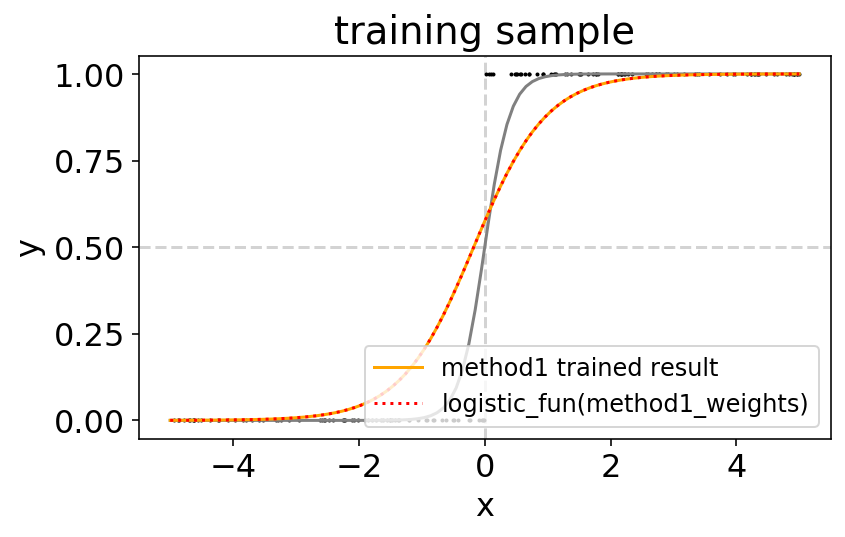

In [10]:
plt.rc('font', size=16)
fig, ax = plt.subplots(1, 1)

ax.scatter(x, y, color='k', s=1)
ax.plot(xl, yl, color='gray')
ax.plot(x_test, Y_predict_test1, color='orange', label='method1 trained result')
ax.plot(x_test, y_fit1, color='r', ls=':', label='logistic_fun(method1_weights)')

ax.axhline(y=0.5, color='lightgray', zorder=-1, ls='--')
ax.axvline(x=0. , color='lightgray', zorder=-1, ls='--')
ax.set_title('training sample')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend(loc='lower right', prop={'size': 12})

fig.tight_layout()

# 2. Method 2

### How to apply softmax activation function & cross entrypy loss on the same problem ?

- link: sigmoid vs softmax activation functions

  https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier
   

- note: 3 kinds of softmax function in pytorch

  https://discuss.pytorch.org/t/whats-difference-of-nn-softmax-nn-softmax-nn-functional-softmax/90934

#### create one-hot-encoded targets

In [11]:
# preparing data
# need to turn Y to a different format (which would be compatible in the multi-classification cases)

Yt = torch.nn.functional.one_hot(Y.long().view(-1), num_classes=2)
print(Yt.shape)
Yt[0:3]

torch.Size([150, 2])


tensor([[0, 1],
        [1, 0],
        [0, 1]])

In [12]:
def softmaxI(y):
    #exp = torch.exp(y)
    #sum_exp = torch.sum(exp, dim=-1, keepdim=True)
    #return exp/sum_exp
    return torch.exp(y)/torch.exp(y).sum(dim=-1, keepdim=True)


class LogisticRegression_multi(nn.Module):
    def __init__(self, input_dim, output_dim):
        '''
            Args:
                output_dim : N classes 
        '''
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x, debug_mode=0, apply_softmax=1):
        '''apply softmax in the end'''
        out = self.linear(x)
        
        if apply_softmax:
            y = softmaxI(out)
        else:
            y = out
        
        if debug_mode and apply_softmax:
            print('nn.functional.sofmax :\n', nn.functional.softmax(out, dim=-1)[0:3])
            print('softmaxI(out) :\n', y[0:3])
            print('softmaxI is consistent with nn.functional.sofmax!')
        
        return y



In [13]:
model2 = LogisticRegression_multi(input_dim=1, output_dim=2)
# test if the model outputs are consistent when using the my own softmax_i v.s. using pytorch's softmax
out2 = model2.forward(X, debug_mode=1)

nn.functional.sofmax :
 tensor([[0.7344, 0.2656],
        [0.2229, 0.7771],
        [0.8156, 0.1844]], grad_fn=<SliceBackward>)
softmaxI(out) :
 tensor([[0.7344, 0.2656],
        [0.2229, 0.7771],
        [0.8156, 0.1844]], grad_fn=<SliceBackward>)
softmaxI is consistent with nn.functional.sofmax!


#### costom Cross Entropy Loss

In [14]:
def CrossEntropyLoss(output, target):        
    loss = - (target*torch.log(output)).sum(dim=-1).mean()
    return loss

nnCrossEntropyLoss = nn.CrossEntropyLoss()

#### training_loop

In [15]:
def training_loop2(num_epochs=500, debug_mode=0):
    
    for epoch in range(num_epochs):
        # forward pass
        Y_predict = model2(X)
        # loss
        # my own loss function
        loss = CrossEntropyLoss(Y_predict, Yt)
        
        if debug_mode:
            Y_raw = model2.forward(X, apply_softmax=0)  
            # For nn.CrossEntropyLoss the target has to be 
            # a single number from the interval [0, #classes] 
            # instead of a one-hot encoded target vector.
            loss_torch = nnCrossEntropyLoss(Y_raw, Y.view(-1).long()).detach()
    
        # backward pass
        loss.backward()
    
        # updates
        optimizer2.step()
    
        # zero gradients
        optimizer2.zero_grad()
    
        if (epoch+1) % 100 == 0 :
            if debug_mode: 
                print(f'epoch: {epoch+1}, loss={loss.item():.4f}, nn.CELoss={loss_torch.item():.4f}')
            else:
                print(f'epoch: {epoch+1}, loss={loss.item():.4f}')
    
    return model2

In [16]:
model2 = LogisticRegression_multi(input_dim=1, output_dim=2)
learning_rate = 0.005
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate)

model2 = training_loop2(num_epochs=2500, debug_mode=1)

epoch: 100, loss=0.4573, nn.CELoss=0.4573
epoch: 200, loss=0.2721, nn.CELoss=0.2721
epoch: 300, loss=0.2117, nn.CELoss=0.2117
epoch: 400, loss=0.1798, nn.CELoss=0.1798
epoch: 500, loss=0.1594, nn.CELoss=0.1594
epoch: 600, loss=0.1450, nn.CELoss=0.1450
epoch: 700, loss=0.1342, nn.CELoss=0.1342
epoch: 800, loss=0.1257, nn.CELoss=0.1257
epoch: 900, loss=0.1189, nn.CELoss=0.1189
epoch: 1000, loss=0.1132, nn.CELoss=0.1132
epoch: 1100, loss=0.1084, nn.CELoss=0.1084
epoch: 1200, loss=0.1043, nn.CELoss=0.1043
epoch: 1300, loss=0.1008, nn.CELoss=0.1008
epoch: 1400, loss=0.0977, nn.CELoss=0.0977
epoch: 1500, loss=0.0949, nn.CELoss=0.0949
epoch: 1600, loss=0.0925, nn.CELoss=0.0925
epoch: 1700, loss=0.0902, nn.CELoss=0.0902
epoch: 1800, loss=0.0882, nn.CELoss=0.0882
epoch: 1900, loss=0.0864, nn.CELoss=0.0864
epoch: 2000, loss=0.0847, nn.CELoss=0.0847
epoch: 2100, loss=0.0832, nn.CELoss=0.0832
epoch: 2200, loss=0.0818, nn.CELoss=0.0818
epoch: 2300, loss=0.0805, nn.CELoss=0.0805
epoch: 2400, loss=0.

### check model2 training result (overplot with model1 result)

In [17]:
with torch.no_grad():
    Y_predict_test2 = model2(X_test)
    y_predict_test2 = Y_predict_test2.numpy()[:,1]

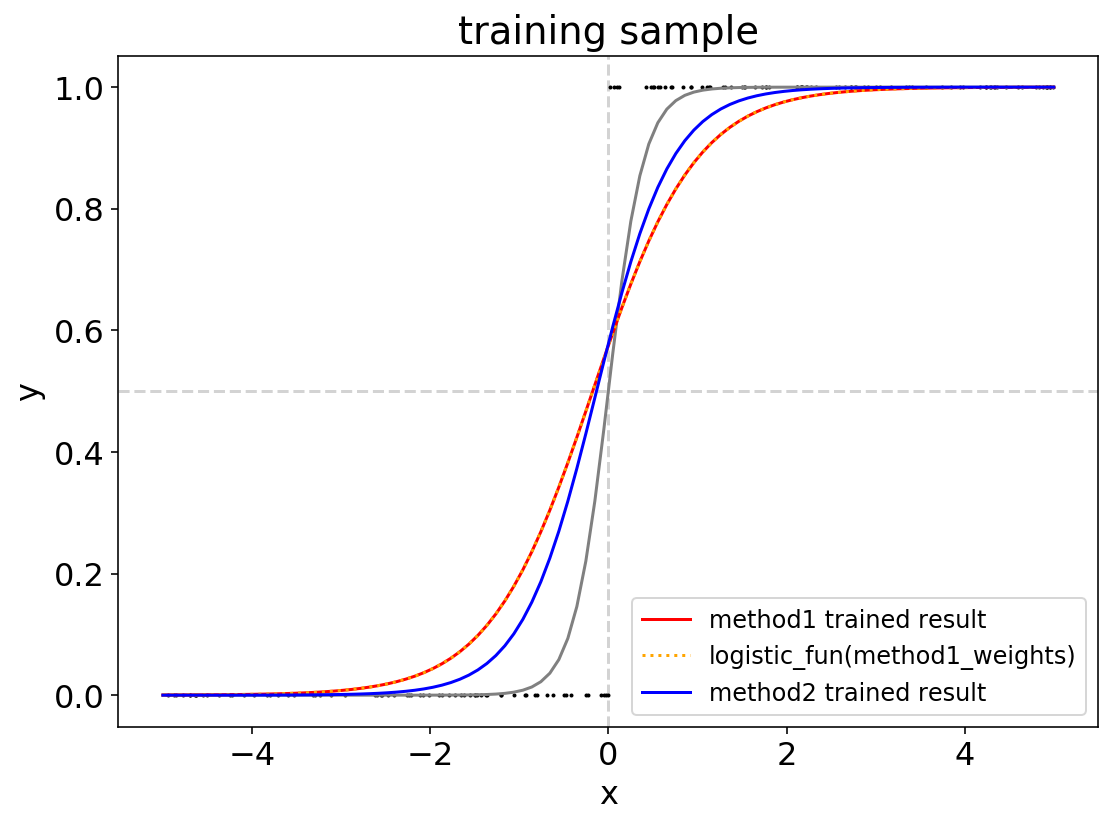

In [18]:
plt.rc('font', size=16)
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.scatter(x, y, color='k',s=1)
ax.plot(xl, yl, color='gray')
ax.plot(x_test, Y_predict_test1, color='r', label='method1 trained result')
ax.plot(x_test, y_fit1, color='orange', ls=':', label='logistic_fun(method1_weights)')
ax.plot(x_test, y_predict_test2, color='b', label='method2 trained result')

# pars = []
# for par in model2.parameters():
#     pars.append(par)
    
# w0_class1 = pars[0][1].detach().numpy()
# w1_class1 = pars[1][1].detach().numpy()

# ax.plot(x_test, logistic_function([w0_class1, w1_class1], xl), color='lightblue', ls=':', label='logistic_fun(method2_1weights)')


ax.axhline(y=0.5, color='lightgray', zorder=-1, ls='--')
ax.axvline(x=0. , color='lightgray', zorder=-1, ls='--')
ax.set_title('training sample')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend(loc='lower right', prop={'size': 12})

fig.tight_layout()

# ------------ Note ------------

### Losses in Pytorch

nn.BCELoss() v.s. nn.BCEWithLogitsLoss() v.s. nn.CrossEntropyLoss()

https://sparrow.dev/cross-entropy-loss-in-pytorch/


- Conclusion: 

    When using nn.BCELoss, need to implement sigmoid activation at the end of the forward pass.
    
    When using nn.BCEWithLogitsLoss() or nn.CrossEntropyLoss(), sigmoid/softmax is automatically computed when calling these two functions. So NO need to implement any activation function at the forward pass.    

### Torch data types

In [19]:
torch.get_default_dtype()

torch.float32

https://jdhao.github.io/2017/11/15/pytorch-datatype-note/

For deep learning, precision is not a very important issue. Plus, GPU can not process double precision very well. So FloatTensor is enough, which is also the default type for model parameters.